### Try different cut off points to eliminate outliers.

In [1]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

In [2]:
import pandas as pd
from nltk import FreqDist
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

In [3]:
# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

In [4]:
# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

In [5]:
# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]

df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

In [6]:
shareTrend = {'tagName' : df_share['index'], 'preGPT': df_share.iloc[:, 641:731].mean(axis = 1, skipna=True),
              'postGPT' : df_share.iloc[:, 731:].mean(axis = 1, skipna=True)}
shareTrend = pd.DataFrame(shareTrend)

In [7]:
# Convert nan to 0
shareTrend.fillna(0, inplace = True)
shareTrend['diff'] = shareTrend['postGPT'] - shareTrend['preGPT']

In [8]:
shareTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,diff
242,nextDOTjs,0.287568,0.452411,0.164843
442,springboot,0.425927,0.546275,0.120348
168,seleniumwebdriver,0.097958,0.218038,0.120081
29,angular,0.495756,0.557043,0.061287
51952,boomerangapp,0.000000,0.053050,0.053050
...,...,...,...,...
149,dataframe,0.563057,0.401511,-0.161546
28,arrays,0.578478,0.361360,-0.217118
72,pandas,0.929865,0.647534,-0.282331
5,javascript,3.548633,3.055816,-0.492817


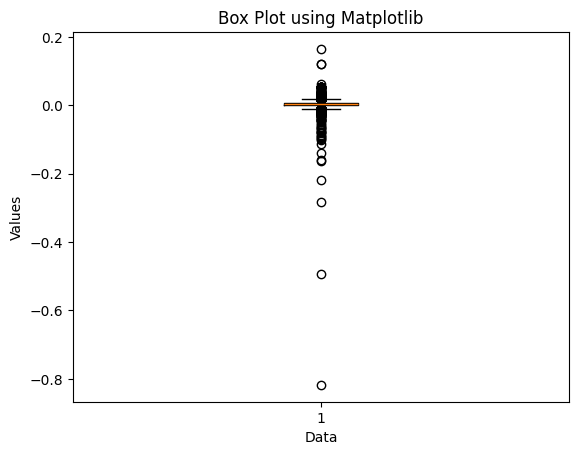

In [9]:
# Create a box plot
plt.boxplot(shareTrend['diff'])
plt.title('Box Plot using Matplotlib')
plt.xlabel('Data')
plt.ylabel('Values')
plt.show()

### 1) Percentile Approach

In [10]:
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result

In [11]:
# try different lower_bounds
percentList = [0, 5, 10, 15, 20, 25]

result_df = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(percentList)):
    lower_bound = np.percentile(shareTrend['diff'], percentList[i]) # try 5, 10, 15, 20, 25
    # filter data without outliers
    cleaned_data = shareTrend[(shareTrend['diff'] >= lower_bound)]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    model = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model = pd.DataFrame({'cut_off_percentage':[percentList[i]], 'coef':[model.params['T_d:P_t']], 'std_err':[model.bse['T_d:P_t']], 'P_val':[model.pvalues['T_d:P_t']]})
    result_df = pd.concat([result_df, result_model], ignore_index = True)
    #result_ls.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_384915/414927433.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, result_model], ignore_index = True)


In [12]:
result_df

,cut_off_percentage,coef,std_err,P_val
0,0,-0.215568,0.016569,1.072930e-38
1,5,0.118419,0.011222,4.974319e-26
2,10,0.191033,0.012077,2.365063e-56
3,15,0.192328,0.012195,4.918823e-56
4,20,0.192328,0.012195,4.918823e-56
5,25,0.192328,0.012195,4.918823e-56


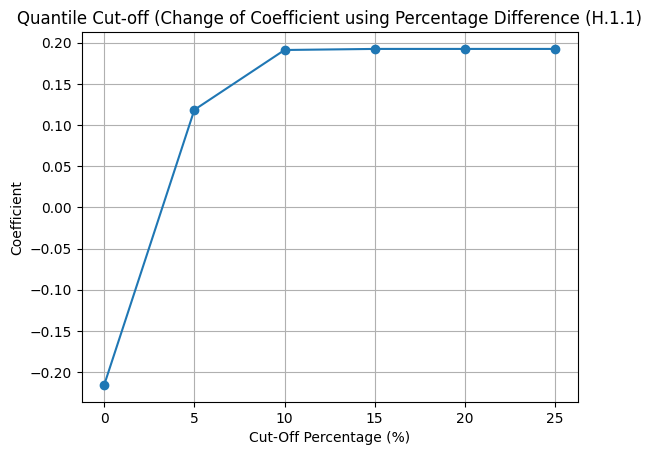

In [13]:
import matplotlib.pyplot as plt
# Plotting the line graph
# Create a figure and an axes
fig, ax = plt.subplots()

ax.plot(result_df['cut_off_percentage'], result_df['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Quantile Cut-off (Change of Coefficient using Percentage Difference (H.1.1)')
ax.set_xlabel('Cut-Off Percentage (%)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Display the plot
plt.show()

### 2) Bottom-K Approach

In [14]:
shareTrend.sort_values('diff', ascending = True).head(10)

,tagName,preGPT,postGPT,diff
17,python,5.378989,4.561351,-0.817638
5,javascript,3.548633,3.055816,-0.492817
72,pandas,0.929865,0.647534,-0.282331
28,arrays,0.578478,0.361360,-0.217118
149,dataframe,0.563057,0.401511,-0.161546
418,sql,0.789951,0.631429,-0.158522
163,list,0.315903,0.176052,-0.139851
21,python3DOTx,0.758491,0.645268,-0.113223
67,html,1.285999,1.183921,-0.102078
38,php,0.838785,0.739441,-0.099344


In [15]:
shareTrend.sort_values('preGPT', ascending = False)

,tagName,preGPT,postGPT,diff
17,python,5.378989,4.561351,-0.817638
5,javascript,3.548633,3.055816,-0.492817
44,reactjs,1.920166,1.832249,-0.087917
63,java,1.592552,1.571811,-0.020741
45,Csharp,1.417443,1.410818,-0.006625
...,...,...,...,...
33764,subobject,0.000000,0.000000,0.000000
33763,rubyffi,0.000000,0.000000,0.000000
33760,slamdata,0.000000,0.000000,0.000000
33759,dynamicfunction,0.000000,0.011746,0.011746


In [16]:
list(shareTrend.sort_values('diff', ascending = True)[0:20].tagName)

['python',
 'javascript',
 'pandas',
 'arrays',
 'dataframe',
 'sql',
 'list',
 'python3DOTx',
 'html',
 'php',
 'mysql',
 'c',
 'flutterlayout',
 'reactjs',
 'Cpp',
 'json',
 'string',
 'r',
 'loops',
 'dictionary']

In [17]:
# cut-off bottom 0, 1, 3, 5, 10, 20]
cutoff_List = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
result_ls_bottomK = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = shareTrend.sort_values('diff', ascending = True)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']]})
    result_ls_bottomK = pd.concat([result_ls_bottomK, result_model_bottomK], ignore_index = True)
    #result_ls_bottomK.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_384915/3470720185.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_ls_bottomK = pd.concat([result_ls_bottomK, result_model_bottomK], ignore_index = True)


In [18]:
result_ls_bottomK

,cut_off_percentage,coef,std_err,P_val
0,0,-0.215568,0.016569,1.072930e-38
1,2,-0.069806,0.010366,1.651228e-11
2,4,-0.046312,0.010819,1.862663e-05
3,6,-0.032246,0.012254,8.501683e-03
4,8,-0.025718,0.012124,3.389866e-02
5,10,-0.022634,0.010866,3.724611e-02
6,12,-0.019197,0.010467,6.663518e-02
7,14,0.023842,0.009187,9.452920e-03
8,16,0.026089,0.008575,2.345686e-03
9,18,0.037882,0.009707,9.521711e-05


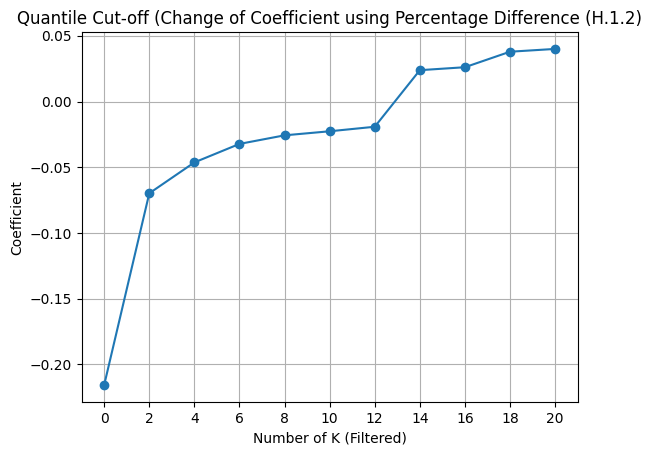

In [19]:
# Plotting the line graph
# Create a figure and an axes
fig, ax = plt.subplots()

ax.plot(result_ls_bottomK['cut_off_percentage'].astype('str'), result_ls_bottomK['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Quantile Cut-off (Change of Coefficient using Percentage Difference (H.1.2)')
ax.set_xlabel('Number of K (Filtered)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Display the plot
plt.show()

### 3. Percentage Share wise Approach

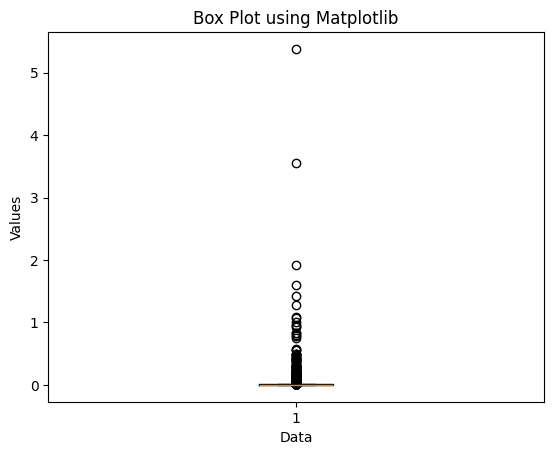

In [20]:
# Create a box plot
plt.boxplot(shareTrend['preGPT'])
plt.title('Box Plot using Matplotlib')
plt.xlabel('Data')
plt.ylabel('Values')
plt.show()

#### 3-1 Percentage-wise

In [21]:
# try different lower_bounds
percentList = [0, 5, 10, 15, 20, 25]

result_vr3 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(percentList)):
    upper_bound = np.percentile(shareTrend['preGPT'], 100 - percentList[i]) # try 5, 10, 15, 20, 25
    # filter data without outliers
    cleaned_data = shareTrend[(shareTrend['preGPT'] <= upper_bound)]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    model = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model = pd.DataFrame({'cut_off_percentage':[percentList[i]], 'coef':[model.params['T_d:P_t']], 'std_err':[model.bse['T_d:P_t']], 'P_val':[model.pvalues['T_d:P_t']]})
    result_vr3 = pd.concat([result_vr3, result_model], ignore_index = True)
    #result_ls.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_384915/1673764378.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr3 = pd.concat([result_vr3, result_model], ignore_index = True)


In [22]:
result_vr3

,cut_off_percentage,coef,std_err,P_val
0,0,-0.215568,0.016569,1.072930e-38
1,5,0.439340,0.031870,3.120826e-43
2,10,0.507956,0.030801,4.220768e-61
3,15,0.596252,0.028793,2.929018e-95
4,20,0.696599,0.029765,3.929503e-121
5,25,0.860597,0.037661,1.430514e-115


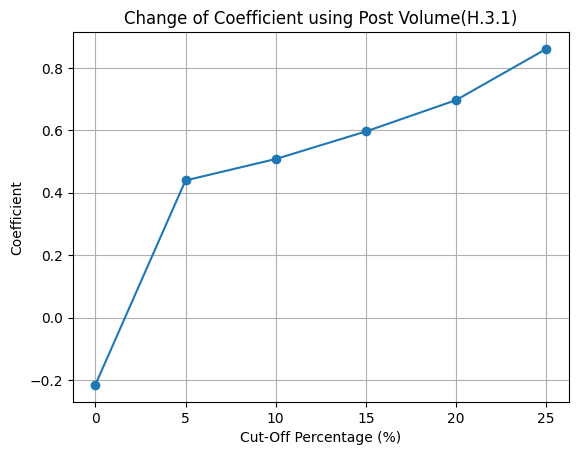

In [23]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_vr3['cut_off_percentage'], result_vr3['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Change of Coefficient using Post Volume(H.3.1)')
ax.set_xlabel('Cut-Off Percentage (%)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Display the plot
plt.show()

#### 3-2 Cut-off Count-wise

In [24]:
list(shareTrend.sort_values('preGPT', ascending= False)[0:20].tagName)

['python',
 'javascript',
 'reactjs',
 'java',
 'Csharp',
 'html',
 'android',
 'r',
 'nodeDOTjs',
 'flutter',
 'css',
 'pandas',
 'php',
 'typescript',
 'Cpp',
 'sql',
 'python3DOTx',
 'arrays',
 'dataframe',
 'django']

In [25]:
# cut-off bottom 0, 1, 3, 5, 10, 20]
cutoff_List = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
result_vr4 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = shareTrend.sort_values('preGPT', ascending= False)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']]})
    result_vr4 = pd.concat([result_vr4, result_model_bottomK], ignore_index = True)

/tmp/ipykernel_384915/1606606187.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr4 = pd.concat([result_vr4, result_model_bottomK], ignore_index = True)


In [26]:
result_vr4

,cut_off_percentage,coef,std_err,P_val
0,0,-0.215568,0.016569,1.072930e-38
1,2,-0.069806,0.010366,1.651228e-11
2,4,-0.065312,0.010104,1.021294e-10
3,6,-0.065399,0.010254,1.796454e-10
4,8,-0.079321,0.010987,5.207039e-13
5,10,-0.077273,0.009160,3.283788e-17
6,12,-0.041753,0.008916,2.826071e-06
7,14,-0.044470,0.008324,9.179605e-08
8,16,-0.030856,0.008396,2.377764e-04
9,18,0.001759,0.007004,8.016720e-01


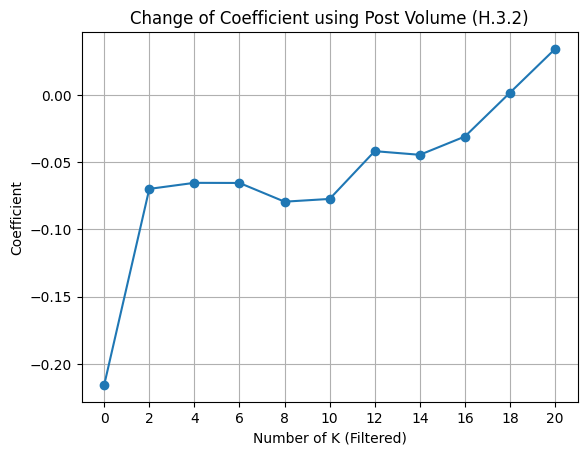

In [27]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_vr4['cut_off_percentage'].astype('str'), result_vr4['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Change of Coefficient using Post Volume (H.3.2)')
ax.set_xlabel('Number of K (Filtered)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Display the plot
plt.show()